# Fase #2: Construcción de un modelo estadístico base

Elías Garza Valdés
A01284041

In [12]:
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

## Leyendo los datos

In [8]:
df = pd.read_csv(r'../Data/precios_autos.csv')
df.head()

,symboling,CarName,fueltype,carbody,drivewheel,enginelocation,wheelbase,carlength,carwidth,carheight,...,enginetype,cylindernumber,enginesize,stroke,compressionratio,horsepower,peakrpm,citympg,highwaympg,price
0,3,alfa-romero giulia,gas,convertible,rwd,front,88.6,168.8,64.1,48.8,...,dohc,four,130,2.68,9.0,111,5000,21,27,13495.0
1,3,alfa-romero stelvio,gas,convertible,rwd,front,88.6,168.8,64.1,48.8,...,dohc,four,130,2.68,9.0,111,5000,21,27,16500.0
2,1,alfa-romero Quadrifoglio,gas,hatchback,rwd,front,94.5,171.2,65.5,52.4,...,ohcv,six,152,3.47,9.0,154,5000,19,26,16500.0
3,2,audi 100 ls,gas,sedan,fwd,front,99.8,176.6,66.2,54.3,...,ohc,four,109,3.40,10.0,102,5500,24,30,13950.0
4,2,audi 100ls,gas,sedan,4wd,front,99.4,176.6,66.4,54.3,...,ohc,five,136,3.40,8.0,115,5500,18,22,17450.0


In [9]:
df = df.drop(columns = ['CarName', 'enginelocation'])
df = pd.get_dummies(df)

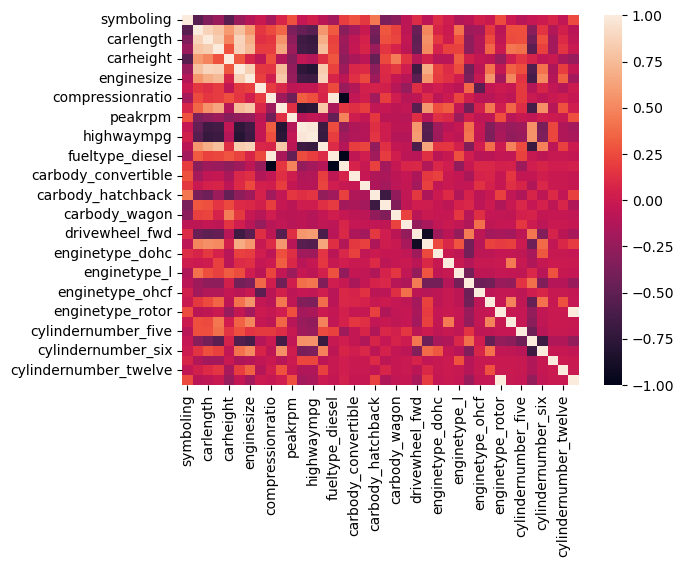

In [13]:
sns.heatmap(df.corr())
plt.show()

Queremos ver que variables son importantes al momento de decidir el precio de un automovil. Por lo tanto, vamos a generar una regresion lineal con las variables para ver si importan al momento de decidir el precio de un automovil. 

Ironicamente, la parte más facil será generar el modelo lo cual haremos a continuación. Despues toca verificar el modelo lo cual ya empieza a ser más complejo. 

In [18]:
from sklearn.linear_model import LinearRegression, SGDRegressor
model = LinearRegression()
model.fit(df.drop(columns = 'price'), df['price'])

LinearRegression()

In [27]:
[model_stat.intercept_] +  list(model_stat.coef_)

[-46298.35495356047,
 -47.150587186348055,
 18.577086953572113,
 -82.2077841717521,
 607.5253710795893,
 186.7355225881091,
 3.515715103081931,
 97.74817546947392,
 -4329.700969603384,
 -243.42650451343053,
 45.58393961205683,
 2.3102647699686853,
 -155.79099865984054,
 225.85765630328902,
 3073.2867269575963,
 -3073.2867269553703,
 2923.609502265532,
 -300.1558218917708,
 -1076.6219209846784,
 -231.47763349034625,
 -1315.3541259112662,
 -193.57422758204194,
 -218.28821859180644,
 411.8624461753853,
 1951.755835812602,
 -13838.964525600866,
 3501.0289830243228,
 5804.986774822784,
 4254.772920402167,
 -4435.1756958764445,
 2761.595707410821,
 8719.804339560087,
 -2902.140337015666,
 -5144.752759285279,
 -214.72897998675813,
 1418.8828720638387,
 -4638.660842755951,
 2761.5957074110174]

In [20]:
y_pred = model.predict(df.drop(columns = 'price'))
residuals = df['price'] - y_pred

0      -267.261957
1      2737.738043
2      4922.835020
3      3403.164879
4       -36.918732
          ...     
200   -2021.972000
201   -2108.410803
202    2414.195364
203   -1983.482353
204    3425.708313
Name: price, Length: 205, dtype: float64

Ahora vamos a revisar si los residuos forman una distribución normal, validando asi el modelo. 

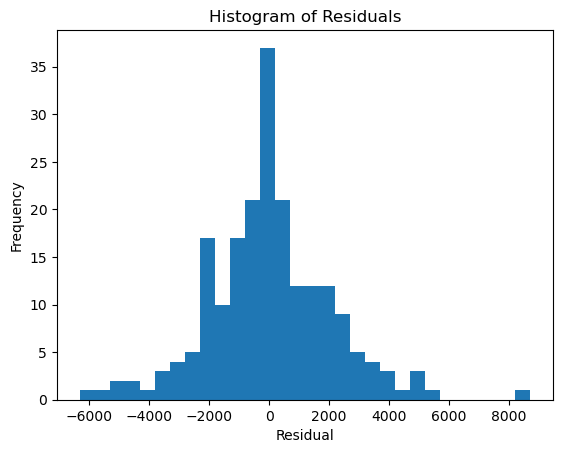

In [21]:
plt.hist(residuals, bins=30)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Histogram of Residuals')
plt.show()

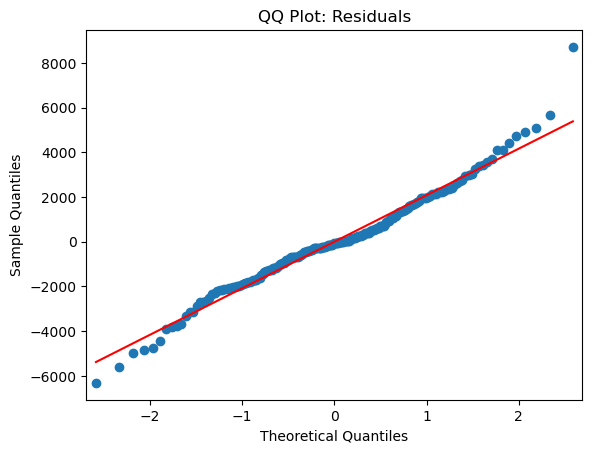

Is data normally distributed: False via Anderson-Darling test with significance of: 90.0 %
K-S test statistic: 0.0732
P-value: 0.2115


In [30]:
sm.qqplot(residuals, line='s')

# Add title and labels
plt.title(f"QQ Plot: Residuals")
plt.xlabel("Theoretical Quantiles")
plt.ylabel("Sample Quantiles")

# Display the plot
plt.show()
result = stats.anderson(residuals)
print("Is data normally distributed:", result.statistic < result.critical_values[1],
        'via Anderson-Darling test with significance of:' ,100 - result.significance_level[1], '%')

data_standardized = (residuals - np.mean(residuals)) / np.std(residuals)
# Perform the K-S test for normality
ks_statistic, ks_p_value = stats.kstest(data_standardized, 'norm')

print(f"K-S test statistic: {ks_statistic:.4f}")
print(f"P-value: {ks_p_value:.4f}")




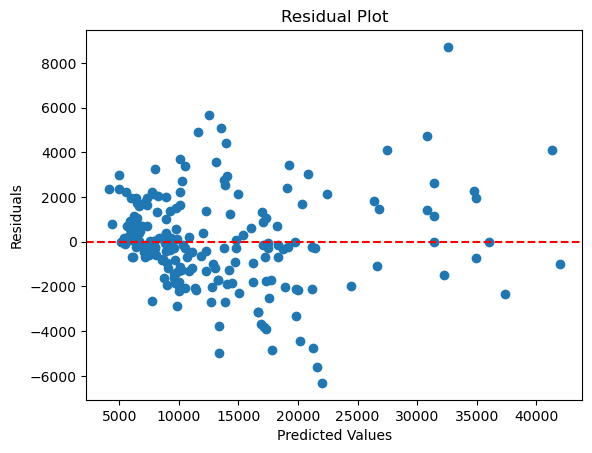

In [22]:
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

Como podemos ver. A pesar de que sí tenemos un modelo este no cumple con nuestras supocisiones estadisticas para poder considerarlo asi que no lo vamos a usar tal cual. Es por esto que vamos a intentar hacer algo diferente.

Primero, calcularemos la distancia de mahalanobis de nuestro dataframe. 

In [36]:
from scipy.spatial import distance
from scipy.stats import chi2

mahalanobis_distances = df.apply(lambda row: distance.mahalanobis(row, df.mean(), np.linalg.inv(df.cov())), axis=1)


Vamos a hacer un PCA y de las combinaciones lineales vemos que variables son lás más importantes

In [70]:
from sklearn.decomposition import PCA
pca = PCA(n_components=15)

pca.fit(df.drop(columns = 'price'))
components = pd.DataFrame(pca.components_).transpose()
components

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,-0.000669,0.000261,0.012177,0.012530,0.045058,-0.061455,-0.176495,0.086122,-0.127951,-0.549911,0.352773,-0.666671,0.135328,-0.172789,0.003240
1,0.008079,0.003158,-0.061972,-0.064260,-0.317848,0.221399,0.536870,-0.644318,-0.271120,-0.076157,-0.109444,-0.194331,-0.009480,-0.032175,0.049691
2,0.017444,0.010535,-0.073878,-0.033185,-0.820849,0.357982,-0.278266,0.318156,-0.044632,0.079534,0.029489,-0.031037,-0.026075,0.025327,-0.005301
3,0.002880,0.002107,-0.001934,-0.004643,-0.053424,0.061316,0.010688,-0.102158,-0.222095,-0.417149,0.522741,0.631076,0.155907,0.136391,-0.099118
4,0.001629,-0.000485,-0.039725,-0.014597,-0.126796,0.110067,0.208333,-0.110122,0.909425,-0.234547,0.136389,-0.011378,0.019505,0.010024,-0.052976
5,0.811765,0.575871,-0.090852,0.004803,0.031548,-0.005649,0.005356,0.008526,0.000025,-0.000097,-0.001138,0.000008,0.000062,-0.001345,0.000564
6,0.055989,0.037741,0.684410,-0.722002,-0.047499,-0.042849,-0.027351,-0.014741,0.020134,-0.006495,-0.005723,0.000367,-0.002361,0.008165,-0.002164
7,0.000089,0.000043,0.000227,-0.004549,0.004506,0.005383,-0.009297,-0.009917,-0.030621,-0.034321,-0.024819,0.018454,-0.264452,-0.307753,-0.107025
8,0.002284,-0.002733,-0.042143,-0.039697,0.210044,0.429859,-0.675156,-0.534955,0.082703,0.018217,-0.066778,0.004715,-0.036066,0.022958,0.015945
9,0.035111,0.061255,0.713097,0.673494,-0.038115,0.169493,0.035733,-0.029819,0.006887,0.013223,0.009176,-0.011272,-0.003570,-0.008113,0.000330


Los valores de la varianza explicada son:

In [71]:
values = list(pca.singular_values_/pca.singular_values_.sum())
values

[0.5363591633343965,
 0.40274063385100417,
 0.02654605182468482,
 0.013400241162347304,
 0.005872668535607486,
 0.004675202996194573,
 0.0025194770616329453,
 0.002242795816194395,
 0.0016250421968085336,
 0.0009694287606541864,
 0.0008840110386454718,
 0.0008150373077508284,
 0.0004916222740912361,
 0.0004661502432392617,
 0.00039247359674812667]

y esta varianza acumulada:


In [72]:
np.array(values).cumsum()

array([0.53635916, 0.9390998 , 0.96564585, 0.97904609, 0.98491876,
       0.98959396, 0.99211344, 0.99435623, 0.99598128, 0.99695071,
       0.99783472, 0.99864975, 0.99914138, 0.99960753, 1.        ])

Esto es bastante bueno ya que solo 2 vectores explica 93% de la varianza. Eso quiere decir que 53% del error lo podemos explicar con una regresion lineal (el qqplot de antes si se ve muy lineal pero las colas no nos permitieron que fuera normal).

In [74]:
pca_matrix = pd.DataFrame(np.transpose(pca.components_), columns=[f'PC{i}' for i in range(15)], index=df.drop(columns = 'price').columns)

pca_matrix = pca_matrix[pca_matrix.columns[:3]]
pca_matrix

,PC0,PC1,PC2
symboling,-0.000669,0.000261,0.012177
wheelbase,0.008079,0.003158,-0.061972
carlength,0.017444,0.010535,-0.073878
carwidth,0.002880,0.002107,-0.001934
carheight,0.001629,-0.000485,-0.039725
curbweight,0.811765,0.575871,-0.090852
enginesize,0.055989,0.037741,0.684410
stroke,0.000089,0.000043,0.000227
compressionratio,0.002284,-0.002733,-0.042143
horsepower,0.035111,0.061255,0.713097


Ahora veremos las 5 variables que más aportan al primer componente principal (en valor absoluto) para saber cuales son las más relevantes.

In [75]:
pca_matrix.sort_values(by = 'PC0', key = lambda x: abs(x)).tail(5)

,PC0,PC1,PC2
carlength,0.017444,0.010535,-0.073878
horsepower,0.035111,0.061255,0.713097
enginesize,0.055989,0.037741,0.684410
peakrpm,-0.579827,0.814163,-0.020735
curbweight,0.811765,0.575871,-0.090852


In [76]:
pca_matrix.sort_values(by = 'PC1', key = lambda x: abs(x)).tail(5)

,PC0,PC1,PC2
carlength,0.017444,0.010535,-0.073878
enginesize,0.055989,0.037741,0.684410
horsepower,0.035111,0.061255,0.713097
curbweight,0.811765,0.575871,-0.090852
peakrpm,-0.579827,0.814163,-0.020735


Vemos que en ambos vectores son casi las mismas variables por lo que podemos decir que estas son las variables importantes. 